In [16]:
import torch
from torch.nn import Sequential, Linear, Parameter, ReLU, ELU
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing, LayerNorm, summary
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, segregate_self_loops, to_networkx
from typing import Any, Dict, List
from torch import Tensor
from torch_geometric.typing import Adj, OptTensor
from torch import Tensor

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


In [17]:
torch.autograd.set_detect_anomaly(True)

In [18]:
class GNNSConv(MessagePassing):
    """Сверточный слой графовой нейронной сети, выполняющий преобразование латентного представления вершин графа.
    """
    def __init__(self, latent_dim: int, num_edge_features: int, alpha: float = 0.01, hidden_layers=[8]) -> None:
        """
        Args:
            in_channels: число фичей в вершинах графа
            alpha: параметр для учета величины обновления X
        """
        super().__init__(aggr="mean")
        self.alpha = alpha
        self.latent_dim = latent_dim

        layers = []
        l = 2 * latent_dim + num_edge_features        
        layers.append(LayerNorm(l))
        for size in hidden_layers:
            layers.append(Linear(l, size))
            layers.append(ELU())
            l = size
        layers.append(Linear(l, latent_dim))
        self.mlp_in = Sequential(*layers)

        # self.mlp_in = Sequential(
        #     Linear(2 * latent_dim + num_edge_features, latent_dim),
        #     ELU(),
        #     Linear(latent_dim, latent_dim)
        # )

        # self.mlp_out = Sequential(
        #     Linear(2 * latent_dim + num_edge_features, latent_dim),
        #     ELU(),
        #     Linear(latent_dim, latent_dim)
        # )
        layers = []
        l = 2 * latent_dim + num_edge_features
        layers.append(LayerNorm(l))
        for size in hidden_layers:
            layers.append(Linear(l, size))
            layers.append(ELU())
            l = size
        layers.append(Linear(l, latent_dim))
        self.mlp_out = Sequential(*layers)


        # self.mlp_psi = Sequential(
        #     Linear(latent_dim * 3 + num_edge_features, latent_dim),
        #     ELU(),
        #     Linear(latent_dim, latent_dim)
        # )        
        layers = []
        l = latent_dim * 3 + num_edge_features
        layers.append(LayerNorm(l))
        for size in hidden_layers:
            layers.append(Linear(l, size))
            layers.append(ELU())
            l = size
        layers.append(Linear(l, latent_dim))
        self.mlp_psi = Sequential(*layers)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()

    def forward(self, X: Tensor, edge_index: Adj, node_attr: Tensor, edge_attr: Tensor) -> Tensor:
        """
        Args:
            X: Латентное представление данных в вершинах графа, [num_nodes, in_channels]    
            edge_index: Разреженная матрица смежности, [2, num_nodes]
            node_attr: Значения параметров в вершинах графа, [num_nodes, num_node_features]
            edge_attr: Значения атрибутов дуг графа, [num_edges, num_edge_features]
        """

        assert X.shape[1] == self.latent_dim, f'Размерность латентного вектора X должна совпадать с размерностью `latent_dim`, получено X.shape={X.shape}, latent_dim={self.latent_dim}'

        # Формирование сообщения j -> i
        self.flow = 'source_to_target'
        phi_in = self.propagate(edge_index, x=X, edge_attr=edge_attr)

        # Формирование сообщения i -> j
        self.flow = 'target_to_source'
        phi_out = self.propagate(edge_index, x=X, edge_attr=edge_attr)

        # Объединение сообщений
        inputs = torch.cat([X, node_attr, phi_in, phi_out], dim=-1)
        psi = self.mlp_psi(inputs)
        X = X + self.alpha * psi
        return X

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: OptTensor) -> Tensor:
        """
        Args:
            x_i: Target node features [num_edges, num_features]
            x_j: Source node features [num_edges, num_features]
            edge_attr: Source node features [num_edges, num_edge_features]
        """
        mlp = self.mlp_in if self.flow == "source_to_target" else self.mlp_out
        tmp = torch.cat([x_j, x_i, edge_attr], dim=-1) 
        out_message = mlp(tmp)
        return out_message

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(aggr={self.aggr}, latent_dim={self.latent_dim})')

In [19]:
class BalanceConv(MessagePassing):
  def __init__(self) -> None:
    super().__init__(aggr='add')

  def _calculate_flows(self, Din, l, Pin, Pout, E=0.95, K=0.03, rho=0.68):
    """Укрупненно рассчитывает потоки газа по трубам.

    Args:
        Din (Tensor): внутренний диаметр труб газопровода, мм
        Pin, Pout (Tensor): абсолютные давления газа, МПа
        K: эквивалентная шероховатость труб, мм
        rho: плотность газа при с.у., кг/м3
        l (Tensor): протяженность газопровода, км
    """
    # print(f'{Din=}')
    # print(f'{l=}')
    # print(f'{Pin=}')
    # print(f'{Pout=}')

    lambda_res = 0.067 * torch.pow(2*K/Din, 0.2)

    # Коэф-т гидр. сопротивления
    lambdah = lambda_res / pow(E, 2)
    delta = torch.tensor(rho/1.20445)
    Tav = torch.tensor(280.) # Условно средняя температура, К
    Zav = torch.tensor(0.92) # Условно коэф-т сжимаемости, безр.

    flows = 3.32 * 1e-6 * torch.pow(Din, 2.5) * torch.sign(torch.subtract(Pin,  Pout)) * torch.sqrt(
        (torch.abs(torch.pow(Pin, 2) - torch.pow(Pout, 2))) /
        (lambdah * delta * Tav * Zav * l)
        + 1e-6
    )

    # print(f">>> in calc flows {flows=}")

    return flows

  def forward(self, P: Tensor, edge_index: Adj, edge_attr: Tensor, node_attr: Tensor) -> Tensor:
    # row, col = edge_index[0], edge_index[1]
    # print(f'>>> balance layer {P=}')

    self.flow = 'source_to_target'
    flows_in = self.propagate(edge_index=edge_index, p=P, edge_attr=edge_attr, node_attr=node_attr)
    
    self.flow = 'target_to_source'
    flows_out = self.propagate(edge_index=edge_index, p=P, edge_attr=edge_attr, node_attr=node_attr)

    nodes_imbalance = torch.subtract(flows_in, flows_out)
    return flows_in, nodes_imbalance
  
  def message(self, p_j: Tensor, p_i: Tensor, node_attr: OptTensor, edge_attr: OptTensor) -> Tensor:
    """Вычисляет небалансы газа в узлах графа.

    Args:
        p_j (Tensor): Значения давления газа в source nodes, МПа.
        p_i (Tensor): Значения давления газа в target nodes, МПа.
        edge_attr (OptTensor): Характеристики дуг:
          - протяженность, км; 
          - внутренний диаметр трубы, мм.

    Returns:
        Tensor: ...
    """
    # print(">>> messaging ...")

    Pin = p_j if self.flow == 'source_to_target' else p_i
    Pout = p_i if self.flow == 'source_to_target' else p_j

    # print(f'{Pin=}')
    # print(f'{Pout=}')

    # src = node_attr[..., -1]
    # index = torch.where(src != 0) # узлы с заданными значаниями давления

    # Pin = Pin.view(-1)
    # Pout = Pout.view(-1)

    # print(f"{Pin=}")
    # print(f"{Pout=}")
    # print(f"{src=}")
    # print(f"{index=}")


    # print(f"Pin view = {Pin.view(-1)}")
    # print(f"Pout= {Pout.view(-1)}")
    # print(f"l = {edge_attr[..., 0]}")
    # print(f"Din = {edge_attr[..., 1]}")

    flows = self._calculate_flows(Din=edge_attr[..., 1], l=edge_attr[..., 0], Pin=Pin.view(-1), Pout=Pout.view(-1)).view(-1, 1)

    # print(f"{flows=}")

    return flows

In [20]:
class GNNProcessor(torch.nn.Module):
    """Обновляет латентные представления вершин графа за счет использования сверточной графовой нейронной сети.
    """
    def __init__(self, out_channels: int, num_edge_features: int, latent_dim: int = 6, num_convs: int = 8) -> None:
        """Инициализация

        Args:
            num_features (int): _description_
            num_classes (int): _description_
            num_edge_features (int): _description_
            latent_dim (int, optional): Размерность латентного пространства значений в вершинах графа (по умолчанию 10).
            num_convs (int, optional): Количество слоев свертки.
        """
        super().__init__()
        # torch.manual_seed(1234)
        self.latent_dim = latent_dim
        self.convs = torch.nn.ModuleList([
            GNNSConv(latent_dim=self.latent_dim,
                      num_edge_features=num_edge_features, 
                      hidden_layers=[16], alpha=1.0) 
                      for _ in range(num_convs)
        ])
        self.final = Linear(latent_dim, out_channels)
        self.balance_conv = BalanceConv()

    def forward(self, data: Data):
        X = torch.zeros((data.num_nodes, self.latent_dim))
        edge_index, node_attr, edge_attr = data.edge_index, data.x, data.edge_attr

        for conv in self.convs:
            X = conv(X, edge_index, node_attr, edge_attr)
            X = F.relu(X)

        P = self.final(X)
        P = F.relu(P)

        # P = F.sigmoid(P) * torch.max(data.x[..., -1])

        # src = torch.tensor(data.x[..., -1])
        # index = torch.where(src > 0) # узлы с заданными значаниями давления
        # # P.view(-1)[index] = src[index]
        # # print(f">>>imbalance layer {P=}")
        # x = P
        # x[..., -1][index] = src[index]

        # print(f"{x=}")
        # print(f"{src=}")
        # print(f"{index=}")
        # x.view[index] = src[index]

        # print(P)
        
        P_ = torch.where(data.x[..., -1] != 0, data.x[..., -1], P.view(-1)).view(-1, 1)

        flows, imbalance = self.balance_conv(P=P_, edge_index=edge_index, edge_attr=edge_attr, node_attr=node_attr)

        # print(f'{flows=}')

        return P, flows, imbalance

# Обучение модели

In [21]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

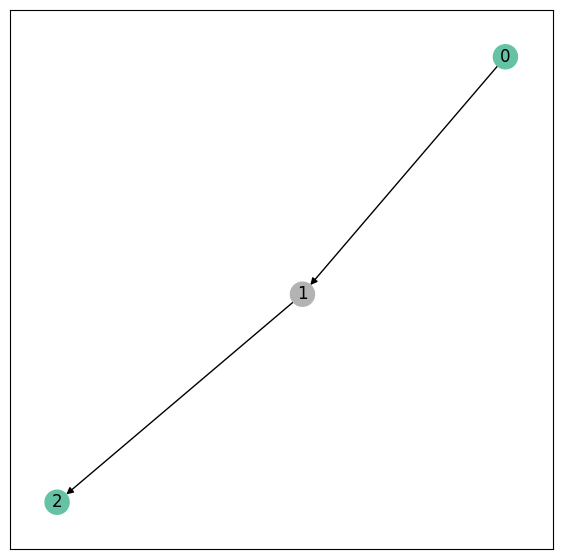

In [22]:
# edge_index = torch.tensor([
#   [0, 1, 2],
#   [1, 2, 3]
# ], dtype=torch.long)

# # Структура данных атрибутов вершин графа:
# # Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
# x = torch.tensor([[0, 7.4], [0.5, 0], [0, 0], [0, 5.4]], dtype=torch.float)

# # Структура данных атрибутов дуг графа:
# # Протяженность, км; Внутренний диаметр трубы, мм
# edge_attr = torch.tensor([
#   [38, 1400],
#   [40, 1400],
#   [43, 1400]
# ])

# data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# G = to_networkx(data, to_undirected=False)
# visualize_graph(G, color=data.x[..., 1] == 0);

edge_index = torch.tensor([
  [0, 1],
  [1, 2]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0, 0], [0, 5.4]], dtype=torch.float)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [55, 1400],
  [60, 1400]])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

G = to_networkx(data, to_undirected=False)
visualize_graph(G, color=data.x[..., 1] == 0);

In [23]:
model = GNNProcessor(out_channels=1, num_edge_features=data.num_edge_features, latent_dim=10, num_convs=3)

print(model)

GNNProcessor(
  (convs): ModuleList(
    (0-2): 3 x GNNSConv(aggr=mean, latent_dim=10)
  )
  (final): Linear(in_features=10, out_features=1, bias=True)
  (balance_conv): BalanceConv()
)


In [24]:
print(summary(model, data=data, max_depth=5))

+-----------------------------+---------------------------------+------------------------+----------+
| Layer                       | Input Shape                     | Output Shape           | #Param   |
|-----------------------------+---------------------------------+------------------------+----------|
| GNNProcessor                |                                 | [3, 1], [3, 1], [3, 1] | 5,789    |
| ├─(convs)ModuleList         | --                              | --                     | 5,778    |
| │    └─(0)GNNSConv          | [3, 10], [2, 2], [3, 2], [2, 2] | [3, 10]                | 1,926    |
| │    └─(1)GNNSConv          | [3, 10], [2, 2], [3, 2], [2, 2] | [3, 10]                | 1,926    |
| │    └─(2)GNNSConv          | [3, 10], [2, 2], [3, 2], [2, 2] | [3, 10]                | 1,926    |
| ├─(final)Linear             | [3, 10]                         | [3, 1]                 | 11       |
| ├─(balance_conv)BalanceConv |                                 | [3, 1], [3, 1]  

In [25]:
class HydraulicsLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, data, P, imbalance):
        psrc = data.x[..., -1]
        sidx = torch.where(psrc > 0) # узлы с заданными значениями давления        
        snidx = torch.where(psrc == 0)[0] # узлы с незаданными значениями давления        

        ploss = torch.nn.MSELoss()

        pl = ploss(psrc[sidx], P.view(-1)[sidx])
        ql = torch.square(imbalance[snidx]).mean()

        beta = 1
        return beta * ql + (1 - beta)*pl

        return ql
    
        return pl #+ ql
    
        loss = torch.square(imbalance[index])
        return loss.mean() + ploss(psrc[index], P.view(-1)[index])

In [26]:
# Test
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')
print(f'loss = {HydraulicsLoss()(data, P, imbalance)}')

P=tensor([[0.7641],
        [0.3509],
        [0.6759]], grad_fn=<ReluBackward0>)
flows=tensor([[   0.0000],
        [ 201.9160],
        [-140.9317]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-201.9160],
        [ 342.8477],
        [-140.9317]], grad_fn=<SubBackward0>)
loss = 117544.5546875


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data.to(device)
criterion = HydraulicsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []
def train():
  model.train()
  optimizer.zero_grad()
  P, _, imbalance = model(data)
  loss = criterion(data, P, imbalance)
  losses.append(loss.item())
  loss.backward()

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)  

  optimizer.step()
  return loss

for epoch in range(500):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')  

Epoch: 000, Loss: 117544.5547
Epoch: 001, Loss: 116756.8984
Epoch: 002, Loss: 114999.6406
Epoch: 003, Loss: 111402.1016
Epoch: 004, Loss: 104063.5391
Epoch: 005, Loss: 90397.4141
Epoch: 006, Loss: 65786.0000
Epoch: 007, Loss: 9832.2949
Epoch: 008, Loss: 8770.9746
Epoch: 009, Loss: 30868.2637
Epoch: 010, Loss: 880.0299
Epoch: 011, Loss: 1241.8494
Epoch: 012, Loss: 7090.7495
Epoch: 013, Loss: 13812.3770
Epoch: 014, Loss: 7514.8022
Epoch: 015, Loss: 2385.4727
Epoch: 016, Loss: 82.4696
Epoch: 017, Loss: 1069.7979
Epoch: 018, Loss: 4955.7598
Epoch: 019, Loss: 6057.1006
Epoch: 020, Loss: 2502.4961
Epoch: 021, Loss: 308.2088
Epoch: 022, Loss: 117.8929
Epoch: 023, Loss: 1036.4291
Epoch: 024, Loss: 1967.0923
Epoch: 025, Loss: 2248.0681
Epoch: 026, Loss: 1760.8823
Epoch: 027, Loss: 880.0027
Epoch: 028, Loss: 160.9264
Epoch: 029, Loss: 41.7132
Epoch: 030, Loss: 559.2396
Epoch: 031, Loss: 1054.9442
Epoch: 032, Loss: 913.9048
Epoch: 033, Loss: 392.5182
Epoch: 034, Loss: 38.3225
Epoch: 035, Loss: 44

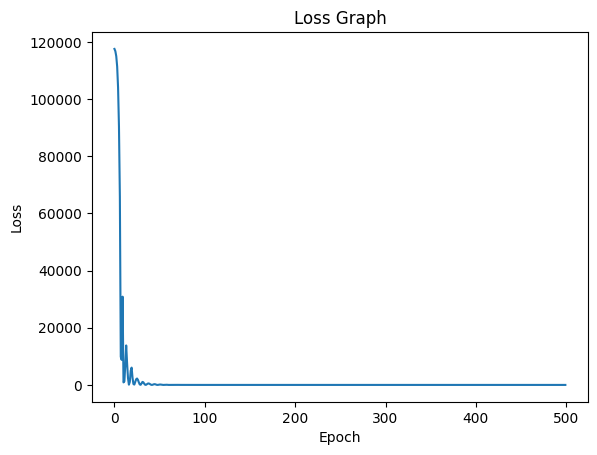

In [28]:
plt.plot(losses)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
%%time
# %%timeit 

# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[4.5722],
        [6.5205],
        [4.5781]], grad_fn=<ReluBackward0>)
flows=tensor([[ 0.0000],
        [95.5833],
        [95.5831]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-9.5583e+01],
        [ 1.2970e-04],
        [ 9.5583e+01]], grad_fn=<SubBackward0>)
CPU times: user 31.4 ms, sys: 7.88 ms, total: 39.3 ms
Wall time: 39.3 ms


# Анализ

In [30]:
# model.convs[0]